In [7]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import itertools
import numpy as np 
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df_orig = pd.read_csv("https://raw.githubusercontent.com/JenBanks8585/Randomdata/main/data/Realty/Zip_ZORI_AllHomesPlusMultifamily_SSA%20(1).csv", parse_dates= True)
print(df_orig.shape)
df_orig.head(3)

(2263, 88)


,RegionID,RegionName,SizeRank,MsaName,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12
0,61639,10025,1,"New York, NY",3025.0,3039.0,3054.0,3068.0,3083.0,3097.0,3112.0,3126.0,3140.0,3155.0,3169.0,3182.0,3196.0,3207.0,3217.0,3227.0,3233.0,3239.0,3244.0,3248.0,3252.0,3257.0,3260.0,3264.0,3268.0,3270.0,3272.0,3274.0,3276.0,3277.0,3279.0,3277.0,3276.0,3275.0,3275.0,3274.0,...,3267.0,3264.0,3263.0,3261.0,3260.0,3260.0,3260.0,3260.0,3262.0,3264.0,3267.0,3270.0,3274.0,3277.0,3281.0,3286.0,3290.0,3298.0,3305.0,3313.0,3324.0,3334.0,3345.0,3353.0,3361.0,3369.0,3361.0,3353.0,3346.0,3311.0,3277.0,3242.0,3201.0,3159.0,3117.0,3073.0,3029.0,2985.0,2938.0,2891.0
1,84654,60657,2,"Chicago, IL",1580.0,1585.0,1591.0,1596.0,1602.0,1607.0,1612.0,1618.0,1623.0,1628.0,1633.0,1638.0,1643.0,1648.0,1653.0,1657.0,1662.0,1666.0,1670.0,1675.0,1679.0,1684.0,1689.0,1694.0,1699.0,1703.0,1708.0,1713.0,1717.0,1722.0,1726.0,1730.0,1735.0,1739.0,1742.0,1745.0,...,1761.0,1762.0,1763.0,1765.0,1766.0,1766.0,1766.0,1767.0,1767.0,1767.0,1767.0,1768.0,1769.0,1770.0,1773.0,1776.0,1778.0,1783.0,1788.0,1793.0,1799.0,1806.0,1812.0,1817.0,1822.0,1827.0,1828.0,1829.0,1830.0,1825.0,1820.0,1816.0,1810.0,1803.0,1797.0,1791.0,1784.0,1777.0,1770.0,1762.0
2,61637,10023,3,"New York, NY",3156.0,3164.0,3172.0,3180.0,3188.0,3195.0,3203.0,3210.0,3218.0,3225.0,3231.0,3237.0,3242.0,3248.0,3254.0,3260.0,3267.0,3274.0,3281.0,3287.0,3294.0,3300.0,3305.0,3309.0,3314.0,3314.0,3313.0,3313.0,3309.0,3305.0,3301.0,3298.0,3295.0,3292.0,3293.0,3295.0,...,3304.0,3303.0,3300.0,3298.0,3296.0,3295.0,3295.0,3295.0,3299.0,3303.0,3306.0,3310.0,3314.0,3317.0,3323.0,3328.0,3333.0,3341.0,3350.0,3358.0,3366.0,3375.0,3384.0,3391.0,3397.0,3404.0,3397.0,3390.0,3383.0,3349.0,3316.0,3282.0,3241.0,3201.0,3160.0,3116.0,3073.0,3029.0,2983.0,2937.0


In [129]:
df_orig['RegionName'].sort_values()

774      1752
1143     1760
857      1801
1773     1851
1178     1852
        ...  
1902    98671
208     98682
1745    98685
701     99205
273     99208
Name: RegionName, Length: 2263, dtype: int64

In [3]:
# Load data and create a dictionary of csv files per location

def load_data():  
  url = "https://raw.githubusercontent.com/JenBanks8585/Randomdata/main/data/Realty/Zip_ZORI_AllHomesPlusMultifamily_SSA%20(1).csv"
  df_orig = pd.read_csv(url, parse_dates = True)
  df= df_orig.copy()
  df = df.drop(['RegionID', 'MsaName', 'SizeRank' ], axis = 1)
  df = df.fillna(method='ffill')

  df_summary = df_orig[['RegionName', 'MsaName']].drop([0])

  # get the list of region ID
  regionId = list(df['RegionName'])

  # Create a dictionary of dataframes for each region ID, with dates as rows.
  reg_dict = {}
  for id, data in df.groupby('RegionName'):
    if id in regionId:
      data.to_csv('/content/csvs/{}.csv'.format(id), header = True, index_label = False)
      reg_dict[id] = pd.read_csv('/content/csvs/{}.csv'.format(id))
  
    else:
      continue

  return df, reg_dict, df_summary

df = load_data()[0]
df_dict = load_data()[1]
df_summary = load_data()[2]

In [4]:
# Convert a dataframe into long format

def long_format(df_):
  tidy = pd.melt(df_, id_vars = ['RegionName'], var_name= 'time')
  tidy['time'] = pd.to_datetime(tidy['time'], infer_datetime_format=True)
  tidy = tidy.dropna(subset = ['value'])
  tidy = tidy.groupby('time').aggregate({'value':'mean'})

  return tidy

long_format(df_dict[2474]).head(3)

,value
time,
2014-01-01,1702.0
2014-02-01,1709.0
2014-03-01,1716.0


In [5]:
# Iterate through all dataframes to convert them to long format

def make_tidy_all():
  for id in df_dict.keys():
    df_dict[id] = long_format(df_dict[id])

  return df_dict

tidy_dict = make_tidy_all()
regionId_keys = list(tidy_dict.keys())

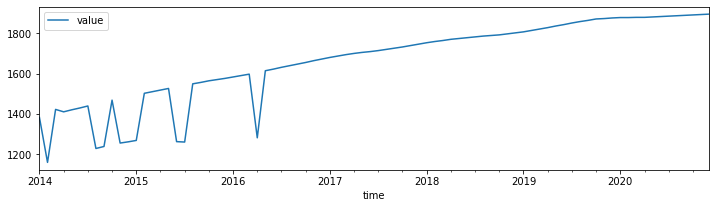

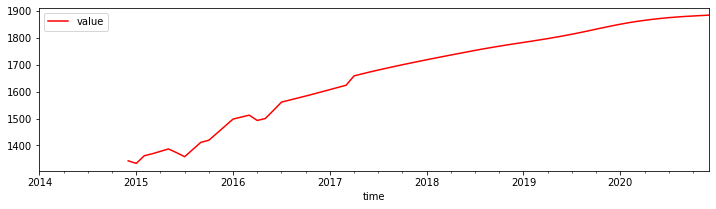

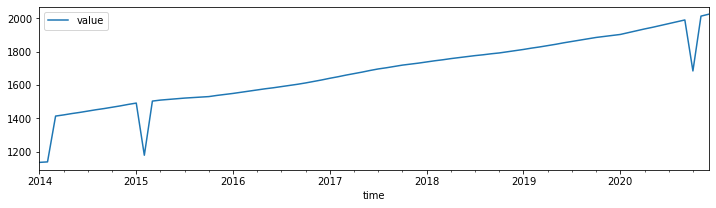

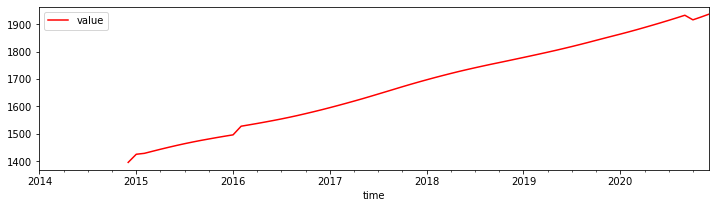

In [6]:
# Plot some of the location's values places with rolling average

for i in regionId_keys[5:7]:
  tidy_dict[i].plot(figsize= (12,3))
  tidy_dict[i].rolling(window=12).mean().plot(figsize = (12,3), color = 'red')

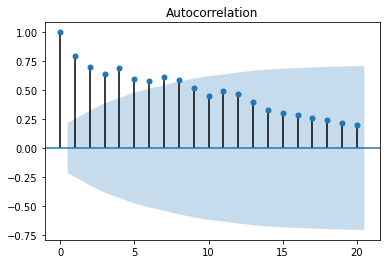

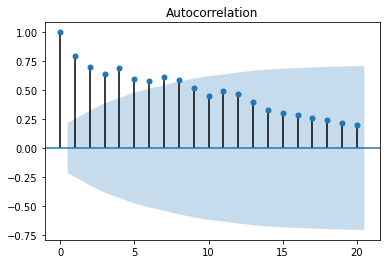

In [8]:
# plot_acf for index 1801 , this is to get an value for q

plot_acf(tidy_dict[1801][['value']]) #for value of q ( 1-7)

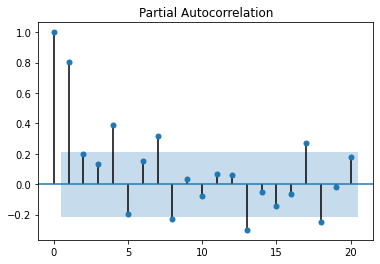

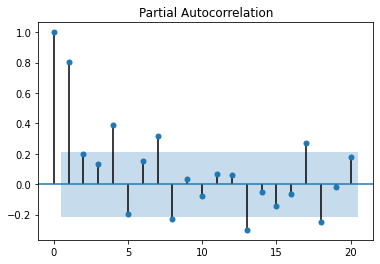

In [9]:
plot_pacf(tidy_dict[1801][['value']]) # For value of P

In [10]:
# Get AIC scores using p=q=d = 1

def get_aic_across():
  AIC = []
  for zipcode in tidy_dict.keys(): 
    mod = sm.tsa.statespace.SARIMAX(tidy_dict[zipcode]['value'],
                                    order=(1, 1, 1),
                                    seasonal_order=(1, 1, 1, 12), 
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    res = mod.fit()
    
    AIC.append([zipcode, np.abs(res.aic)])

#Putting information into dataframe
  AIC_df = pd.DataFrame(AIC, columns = ["zip", 'aic'])
  return AIC_df, res

In [11]:
results_sarimax = get_aic_across()[1]
results_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              value   No. Observations:                   84
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -309.796
Date:                            Sat, 06 Feb 2021   AIC                            629.592
Time:                                    03:58:14   BIC                            639.808
Sample:                                01-01-2014   HQIC                           633.562
                                     - 12-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0946      0.381      0.248      0.804      -0.652       0.842
ma.L1         -0.8277      0.165     -5.013      0.000      -1.151      -0.504
ar.S.L12      -0.0929      0.276     -0.337      0.736      -0.634       0.448
ma.S.L12      -0.3180      0.280     -1.136      0.256      -0.866       0.230
sigma2      2966.4404    264.544     11.213      0.000    2447.943    3484.938
===================================================================================
Ljung-Box (Q):                       15.14   Jarque-Bera (JB):               394.86
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.24   Skew:                            -1.69
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
# Creates a dataframe of different models based on location
# Because of the number of locations, the model generation was divided into segments.
# Note there are a total of 2263 locations, in this cell, we are just running the first 20


def get_model(begin_index=0, end_index=20):
  model = []
  for zipcode in list(tidy_dict.keys())[begin_index:end_index]: 
    mod = sm.tsa.statespace.SARIMAX(tidy_dict[zipcode]['value'],
                                    order=(1, 1, 1),
                                    seasonal_order=(1, 1, 1, 12), 
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    
    res = mod.fit()
    
    model.append([zipcode, res])

# Putting information into dataframe
  model_df = pd.DataFrame(model, columns = ["zip", 'model'])
  return model_df

In [15]:
model_0_20 = get_model(0, 20)
model_0_20.head()

,zip,model
0,1752,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,1760,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,1801,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,1851,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,1852,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


In [ ]:
# Run the rest of the locations and instantiate them

model_20_500 = get_model(100:500)
model_500_1000 = get_model(500:1000)
model_1000_1500 = get_model(1000:1500)
model_1500_2000 = get_model(1500:2000)
model_last = get_model(2000:)

In [17]:
import pickle

with open('/content/pickles/model_0_20.pkl', 'wb') as f:
  pickle.dump(model_0_20, f)

with open('/content/pickles/model_0_20.pkl', 'wb') as f:
  pickle.dump(model_0_20, f)

with open('/content/pickles/model_0_20.pkl', 'wb') as f:
  pickle.dump(model_0_20, f)



In [ ]:
# Pickle the models

model_list = [model_0_20, 
              model_20_500, 
              model_500_1000, 
              model_1000_1500, 
              model_1500_2000, 
              model_last]

for i in range(len(model_list)):
  with open(f'/content/pickles/str{model_list[i]}', 'wb') as mod:
    pickle.dump(model_list[i], mod)

In [19]:
# Access the models

file = open("/content/pickles/model_0_20.pkl", 'rb')
df_20 = pickle.load(file)

file = open("/content/pickles/model_20_500.pkl", 'rb')
df_500 = pickle.load(file)

file = open("/content/pickles/model_500_1000.pkl", 'rb')
df_1000 = pickle.load(file)

file = open("/content/pickles/model_1000_1500.pkl", 'rb')
df_1500 = pickle.load(file)

file = open("/content/pickles/model_1500_2000.pkl", 'rb')
df_2000 = pickle.load(file)

file = open("/content/pickles/model_last.pkl", 'rb')
df_last = pickle.load(file)


# Concatenate the dataframes of zip codes/model

model_df_all= pd.concat([df_20, df_500, df_1000, df_1500, df_2000, df_last])

In [21]:
# Gives forecast given zip code, number of months to forecast and the model dataframe

def get_forecast(zip, steps):
  if zip in list(model_df_all['zip']):   
  
    forecast = model_df_all.loc[model_df_all['zip'] == zip, 'model'].item().get_forecast(steps = steps)
    forecast_conf = forecast.conf_int()
    return forecast_conf
  return "This location is not available"

In [22]:
get_forecast(	1752, 6)

,lower value,upper value
2021-01-01,1669.490492,1674.893644
2021-02-01,1667.457448,1678.461767
2021-03-01,1664.597923,1682.118036
2021-04-01,1661.970767,1686.767107
2021-05-01,1657.064202,1689.774600
2021-06-01,1651.983733,1693.151114


In [23]:
# Create a dataframe of the next 5-months low/high forecasts.

dfs= []
for zip in model_df_all['zip']:
  d = get_forecast(zip, 5)
  dfs.append(d)
  forecast_5months = pd.concat(dfs, axis =1, names = zip_codes)

# Create a csv file
forecast_5months.to_csv('forecast_5months.csv')
forecast_5months.head()

,lower value,upper value,lower value.1,upper value.1,lower value.2,upper value.2,lower value.3,upper value.3,lower value.4,upper value.4,lower value.5,upper value.5,lower value.6,upper value.6,lower value.7,upper value.7,lower value.8,upper value.8,lower value.9,upper value.9,lower value.10,upper value.10,lower value.11,upper value.11,lower value.12,upper value.12,lower value.13,upper value.13,lower value.14,upper value.14,lower value.15,upper value.15,lower value.16,upper value.16,lower value.17,upper value.17,lower value.18,upper value.18,lower value.19,upper value.19,...,lower value.2243,upper value.2243,lower value.2244,upper value.2244,lower value.2245,upper value.2245,lower value.2246,upper value.2246,lower value.2247,upper value.2247,lower value.2248,upper value.2248,lower value.2249,upper value.2249,lower value.2250,upper value.2250,lower value.2251,upper value.2251,lower value.2252,upper value.2252,lower value.2253,upper value.2253,lower value.2254,upper value.2254,lower value.2255,upper value.2255,lower value.2256,upper value.2256,lower value.2257,upper value.2257,lower value.2258,upper value.2258,lower value.2259,upper value.2259,lower value.2260,upper value.2260,lower value.2261,upper value.2261,lower value.2262,upper value.2262
2021-01-01,1669.490492,1674.893644,1933.302221,1942.738011,2003.206969,2023.919893,1381.968676,1553.652390,1377.769652,2006.358352,1791.457903,2041.093738,1906.838042,2067.952368,1776.418187,2186.226560,2623.137248,2637.760213,2579.277953,3119.414833,1900.827013,6210.447582,2178.233941,2192.060683,2295.500046,2353.706139,2448.920209,2460.543905,2523.341878,2533.054129,2699.465439,2713.060555,2746.017241,2757.052708,3536.461316,3649.479397,1922.951893,3492.781262,2364.858779,2375.479195,...,2177.207344,2181.995669,1902.269807,1906.763340,1302.022872,2101.346370,1551.590770,1559.034779,1526.796658,1533.279905,1713.405568,1817.789584,1436.817446,1440.543167,1340.171833,1484.447208,2135.926990,2141.064468,151.335605,3879.731433,1674.254455,1840.287544,1660.738599,1665.377548,2317.237566,2324.016913,1436.513598,1439.963576,1547.525614,1551.382418,1399.146646,1998.018101,1640.972679,1645.386696,2158.778032,2163.413894,1172.867832,1341.438262,1355.756236,1569.255920
2021-02-01,1667.457448,1678.461767,1919.070700,1940.532890,1984.920097,2015.987243,1421.109652,1592.127609,1372.577866,2003.057049,1796.814203,2068.081059,1920.043278,2081.259363,1848.205670,2283.899911,2596.453358,2628.574755,2548.677705,3092.046601,2048.212785,6364.112582,2127.563994,2157.915088,2198.496960,2321.405831,2396.325338,2422.078956,2485.716356,2506.878805,2652.506993,2681.318950,2744.231684,2768.785526,3493.266118,3654.066884,1816.009007,3391.754018,2375.303191,2391.349374,...,2185.782966,2194.863094,1910.551792,1918.876370,1293.636570,2121.359040,1558.047959,1573.191720,1531.958203,1545.138800,1714.520959,1840.887672,1439.307359,1446.459815,1342.847554,1492.911125,2152.712289,2163.230165,-379.784758,3347.094134,1674.343733,1847.130082,1664.304113,1673.354678,2334.835964,2349.690373,1439.606212,1446.018655,1551.861112,1559.410798,1575.625751,2198.161317,1645.432816,1653.692338,2166.293448,2175.522750,1181.686474,1350.987341,1358.264769,1579.238264
2021-03-01,1664.597923,1682.118036,1904.546154,1939.975767,1966.576178,2006.766178,1419.747461,1590.712321,1371.404034,2006.845793,1817.380456,2096.576279,1930.897276,2092.119750,1866.850471,2324.094882,2568.077963,2621.143441,2342.866446,2910.398817,1353.349085,5729.487810,2075.211042,2125.831891,2093.790087,2294.408257,2341.932052,2384.990820,2446.267527,2481.394007,2602.294068,2649.841390,2741.973648,2781.959430,3455.503428,3651.135692,1680.992294,3257.596819,2386.032759,2406.930609,...,2193.840403,2207.583159,1918.400374,1930.839042,1041.175444,1871.685846,1563.338176,1586.579452,1537.214493,1557.916071,1719.949236,1856.935161,1441.103603,1452.112316,1346.029738,1503.133654,2169.504076,2186.417580,-262.631549,3458.052428,1680.115144,1858.928781,1667.745555,1681.801160,2351.28

# Visualization


In [135]:
# Get forecast price based on zip and number of forecast values

def plot_forecast(zip, steps):
  forecast = model_df_all.loc[model_df_all['zip'] == zip, 'model'].item().get_forecast(steps = steps)
  forecast_conf = forecast.conf_int()
  ax = tidy_dict[zip]['value'].plot(label='Observed', figsize= (10, 8))
  forecast.predicted_mean.plot(ax=ax, label='Forecast')
  ax.fill_between(forecast_conf.index,
                    forecast_conf.iloc[:, 0],
                    forecast_conf.iloc[:, 1], color='k', alpha=.25)
  
  df_name = df_orig.copy()
  df_name = df_name[['RegionName', 'MsaName']]
  reg_name = df_name.loc[df_name['RegionName'] ==1752, 'MsaName'].item()

  ax.set_xlabel('Year')
  ax.set_ylabel('Property Rental Price')
  plt.title(reg_name)
  plt.legend()
  plt.show()

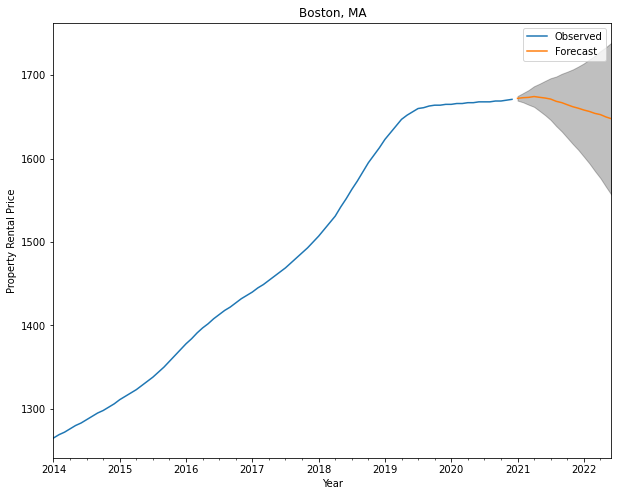

In [136]:
plot_forecast(1752, 18)

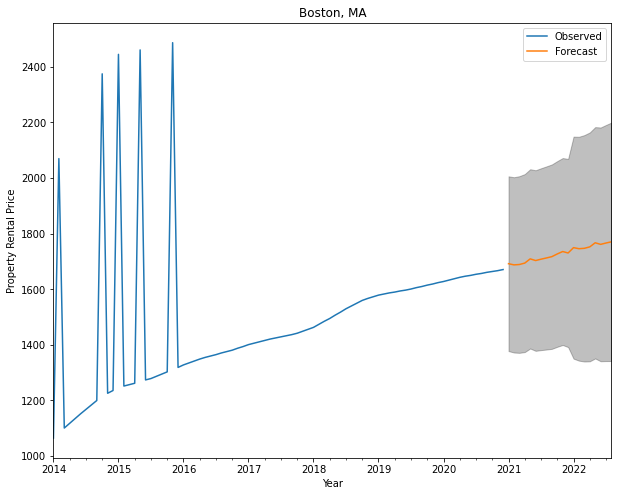

In [137]:
plot_forecast(1852, 20)

# Forecasting based on Zipcode

In [ ]:
!pip install uszipcode

In [37]:
# Grabbing the corresponding cities, states and counties of the zipcodes in the dataset
from uszipcode import SearchEngine
search = SearchEngine(simple_zipcode=True)

city = []
state = []
county = []
for zip in list(df_dict.keys()):
  search = SearchEngine(simple_zipcode=True)
  cityi = search.by_zipcode(zip).city
  statei = search.by_zipcode(zip).state
  countyi = search.by_zipcode(zip).county

  city.append(cityi)
  state.append(statei)
  county.append(countyi)

In [42]:
# Doubling each item because we have a low and high values per zipcode

zip_codes =list(df_dict.keys())
zip_codes2 = list(itertools.chain.from_iterable(itertools.repeat(x, 2) for x in zip_codes))
level = ['low', 'high'] * len(zip_codes)

cities = list(itertools.chain.from_iterable(itertools.repeat(x, 2) for x in city))
states = list(itertools.chain.from_iterable(itertools.repeat(x, 2) for x in state))
counties = list(itertools.chain.from_iterable(itertools.repeat(x, 2) for x in county))



In [50]:
#Converting index to datetime object

forecast_5months.index = pd.to_datetime(forecast_5months.index, format='%Y%m%d',errors='ignore')

# Casting all values to integer
for col in forecast_5months.columns:
  forecast_5months[col] = forecast_5months[col].astype(int)

# Transposing the dataframe
forecast_5months= forecast_5months.T
forecast_5months = forecast_5months.reset_index(drop = True)
forecast_5months.head()

,2021-01-01,2021-02-01,2021-03-01,2021-04-01,2021-05-01
0,1669,1667,1664,1661,1657
1,1674,1678,1682,1686,1689
2,1933,1919,1904,1889,1873
3,1942,1940,1939,1940,1940
4,2003,1984,1966,1949,1929


In [52]:
# Instantiate a new dataframe with other info

label_df = pd.DataFrame()
label_df['zip']= zip_codes2
label_df['city']= cities
label_df['zip']= label_df['zip'].apply(lambda x: str(x).zfill(5))
label_df['county']= counties
label_df['state']= states
label_df['level']= level

# Concatenate other info and forecast
forecast_label = pd.concat([label_df, forecast_5months], axis = 1)
forecast_label.tail()

,zip,city,county,state,level,2021-01-01,2021-02-01,2021-03-01,2021-04-01,2021-05-01
4521,98685,Vancouver,Clark County,WA,high,2163,2175,2188,2201,2214
4522,99205,Spokane,Spokane County,WA,low,1172,1181,1188,1238,1202
4523,99205,Spokane,Spokane County,WA,high,1341,1350,1359,1410,1375
4524,99208,Spokane,Spokane County,WA,low,1355,1358,1364,1372,1379
4525,99208,Spokane,Spokane County,WA,high,1569,1579,1589,1600,1611


In [53]:
# Try it
forecast_label[forecast_label["city"]=="Evanston"]

,zip,city,county,state,level,2021-01-01,2021-02-01,2021-03-01,2021-04-01,2021-05-01
2386,60202,Evanston,Cook County,IL,low,1554,1542,1529,1515,1501
2387,60202,Evanston,Cook County,IL,high,1561,1557,1554,1550,1548


In [54]:
city_df = forecast_label[['zip', 'level', '2021-01-01',	'2021-02-01',	'2021-03-01',	'2021-04-01',	'2021-05-01']]
city_df.columns = ['zip', 'level', 'in_1_month', 'in_2_months', 'in_3_months', 'in_4_months', 'in_5_months']
city_df.head()

,zip,level,in_1_month,in_2_months,in_3_months,in_4_months,in_5_months
0,01752,low,1669,1667,1664,1661,1657
1,01752,high,1674,1678,1682,1686,1689
2,01760,low,1933,1919,1904,1889,1873
3,01760,high,1942,1940,1939,1940,1940
4,01801,low,2003,1984,1966,1949,1929


In [60]:
# Grab csv version of database table 'cities'

df = pd.read_csv("/content/city.csv", index_col = [0])

# Take a subset
df_city = df[['city_id',	'city_name', 'state_abbreviation']]
df_city.head()

,city_id,city_name,state_abbreviation
0,100124,Abbeville ...,AL
1,100460,Adamsville ...,AL
2,100484,Addison ...,AL
3,100676,Akron ...,AL
4,100820,Alabaster ...,AL


In [61]:
# Get the one word version of the city names

places = []
for place in list(df_city['city_name']):
  place = place.split(" ")[0]
  places.append(place)

df_city['city'] = places
df_city = df_city.drop(columns = ['city_name'])
df_city.head(3)

,city_id,state_abbreviation,city
0,100124,AL,Abbeville
1,100460,AL,Adamsville
2,100484,AL,Addison


In [64]:
# merge the two dataframes to get city_id, this will be used as foreign_key to connect to other tables in the database

new_df = forecast_label.merge(df_city, how = "left", left_on = ['city', 'state'], right_on = ['city', 'state_abbreviation'])
new_df= new_df.dropna()

# 
city_i = []
for i in new_df['city_id']:
  id = int(i)
  city_i.append(id)

new_df['city_id'] = city_i


# Using Zipcode as index

In [65]:
# Renaming columns

zip_df = new_df[['zip', 'city_id', 'level', '2021-01-01',	'2021-02-01',	'2021-03-01',	'2021-04-01',	'2021-05-01']]
zip_df.columns = ['zip', 'city_id', 'level', 'in_1_month', 'in_2_months', 'in_3_months', 'in_4_months', 'in_5_months']
zip_df.head(3)

,zip,city_id,level,in_1_month,in_2_months,in_3_months,in_4_months,in_5_months
0,01752,2538715,low,1669,1667,1664,1661,1657
1,01752,2538715,high,1674,1678,1682,1686,1689
4,01801,2581035,low,2003,1984,1966,1949,1929


In [67]:
# # pivot table
city_d = pd.pivot_table(zip_df, index = ['zip'], columns = 'level', values = ['in_1_month', 
                                                                              'in_2_months', 
                                                                              'in_3_months', 
                                                                              'in_4_months', 
                                                                              'in_5_months'])
city_d.head(5)

in_1_month       in_2_months        ... in_4_months       in_5_months      
level       high   low        high   low  ...        high   low        high   low
zip                                       ...                                    
01752       1674  1669        1678  1667  ...        1686  1661        1689  1657
01801       2023  2003        2015  1984  ...        1998  1949        1986  1929
01851       1553  1381        1592  1421  ...        1601  1430        1573  1402
01852       2006  1377        2003  1372  ...        2014  1374        2031  1386
01960       2041  1791        2068  1796  ...        2074  1790        2111  1822

[5 rows x 10 columns]

In [69]:
# Grabbing items in the dataframe

index = [int(i) for i in  list(city_d.index)]

in_1_month_high = list(city_d[( 'in_1_month', 'high')])
in_1_month_low = list(city_d[( 'in_1_month', 'low')])
in_2_month_high = list(city_d[( 'in_1_month', 'high')])
in_2_month_low = list(city_d[( 'in_1_month', 'low')])
in_3_month_high = list(city_d[( 'in_1_month', 'high')])
in_3_month_low = list(city_d[( 'in_1_month', 'low')])
in_4_month_high = list(city_d[( 'in_1_month', 'high')])
in_4_month_low = list(city_d[( 'in_1_month', 'low')])
in_5_month_high = list(city_d[( 'in_1_month', 'high')])
in_5_month_low = list(city_d[( 'in_1_month', 'low')])

In [70]:
# Creating a list of dictionaries zip:forecast
zip_dict =[]
for i in range(len(city_d.index)):
  a = {str(index[i]): [{'in_1_month':{'low':in_1_month_low[i], 'high':in_1_month_high[i]}},
                       {'in_2_months':{'low':in_2_month_low[i], 'high':in_2_month_high[i]}},
                       {'in_3_months':{'low':in_3_month_low[i], 'high':in_3_month_high[i]}},
                       {'in_4_months':{'low':in_4_month_low[i], 'high':in_4_month_high[i]}},
                       {'in_5_months':{'low':in_5_month_low[i], 'high':in_5_month_high[i]}}
                       
                       ]
       }
  zip_dict.append(a)

In [100]:
# Get forecast given zip code

zips = [list(zip_dict[i].keys())[0] for i in range(len(zip_dict))]

def get_forecast(zip):
  if zip in zips:
    for i in range(len(zip_dict)):
      zip = list(zip_dict[i].keys())[0]
      f = zip_dict[i][zip]
      return f
  else:
    return "No forecast for this location"



In [102]:
get_forecast('175332')

'No forecast for this location'

In [103]:
get_forecast('1752')

[{'in_1_month': {'high': 1674, 'low': 1669}},
 {'in_2_months': {'high': 1674, 'low': 1669}},
 {'in_3_months': {'high': 1674, 'low': 1669}},
 {'in_4_months': {'high': 1674, 'low': 1669}},
 {'in_5_months': {'high': 1674, 'low': 1669}}]

In [138]:
import json

with open('zip_dict.json', 'w') as json_file:
    json.dump(zip_dict, json_file)

# Forecasting Based on city_id

In [142]:
# # pivot table
city_d= pd.pivot_table(zip_df, index = ['city_id'], columns = 'level', values = ['in_1_month', 
                                                                              'in_2_months', 
                                                                              'in_3_months', 
                                                                              'in_4_months', 
                                                                              'in_5_months'])
city_d.head(3)

in_1_month         in_2_months  ... in_4_months in_5_months         
level         high     low        high  ...         low        high      low
city_id                                 ...                                 
100820     1443.00  1256.0      1464.0  ...     1236.00     1478.00  1236.00
107000     1383.75  1224.0      1391.5  ...     1231.25     1403.25  1227.75
111416     1424.00  1256.0      1422.0  ...     1260.00     1434.00  1260.00

[3 rows x 10 columns]

In [143]:
index = [int(i) for i in  list(city_d.index)]

in_1_month_high = list(city_d[( 'in_1_month', 'high')])
in_1_month_low = list(city_d[( 'in_1_month', 'low')])
in_2_month_high = list(city_d[( 'in_1_month', 'high')])
in_2_month_low = list(city_d[( 'in_1_month', 'low')])
in_3_month_high = list(city_d[( 'in_1_month', 'high')])
in_3_month_low = list(city_d[( 'in_1_month', 'low')])
in_4_month_high = list(city_d[( 'in_1_month', 'high')])
in_4_month_low = list(city_d[( 'in_1_month', 'low')])
in_5_month_high = list(city_d[( 'in_1_month', 'high')])
in_5_month_low = list(city_d[( 'in_1_month', 'low')])

In [147]:
city_id_dict =[]
for i in range(len(city_d.index)):
  a = {str(index[i]): [{'in_1_month':{'low':in_1_month_low[i], 'high':in_1_month_high[i]}},
                       {'in_2_months':{'low':in_2_month_low[i], 'high':in_2_month_high[i]}},
                       {'in_3_months':{'low':in_3_month_low[i], 'high':in_3_month_high[i]}},
                       {'in_4_months':{'low':in_4_month_low[i], 'high':in_4_month_high[i]}},
                       {'in_5_months':{'low':in_5_month_low[i], 'high':in_5_month_high[i]}}
                       
                       ]
       }
  city_id_dict.append(a)


In [148]:
city_id_dict[0]

{'100820': [{'in_1_month': {'high': 1443.0, 'low': 1256.0}},
  {'in_2_months': {'high': 1443.0, 'low': 1256.0}},
  {'in_3_months': {'high': 1443.0, 'low': 1256.0}},
  {'in_4_months': {'high': 1443.0, 'low': 1256.0}},
  {'in_5_months': {'high': 1443.0, 'low': 1256.0}}]}

In [149]:
# save json object

with open('city_id_dict.json', 'w') as json_file:
    json.dump(city_id_dict, json_file)

In [153]:
# Get forecast given city_id

ids = [list(city_id_dict[i].keys())[0] for i in range(len(city_id_dict))]

def get_forecast_id(city_id):
  if city_id in ids:
    for i in range(len(city_id_dict)):
      c_id = list(city_id_dict[i].keys())[0]
      f = city_id_dict[i][city_id]
      return f
  else:
    return "No forecast for this location"

In [155]:
get_forecast_id('100820')

[{'in_1_month': {'high': 1443.0, 'low': 1256.0}},
 {'in_2_months': {'high': 1443.0, 'low': 1256.0}},
 {'in_3_months': {'high': 1443.0, 'low': 1256.0}},
 {'in_4_months': {'high': 1443.0, 'low': 1256.0}},
 {'in_5_months': {'high': 1443.0, 'low': 1256.0}}]